In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.gaussian_process import kernels

## Preprocessing step
from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

from scipy.spatial.distance import cdist

import h5py
#import plotly.graph_objects as go
#from mpl_toolkits.mplot3d import Axes3D

def read_cgns_coordinates(file_path):
    with h5py.File(file_path, 'r') as file:
        # We retrieve coordinate by coordinate.
        # ! Notice the space before the data. This is due to the naming in the files themselves.
        x = np.array(file['Base_2_3/Zone/GridCoordinates/CoordinateX'].get(' data'))
        y = np.array(file['Base_2_3/Zone/GridCoordinates/CoordinateY'].get(' data'))
        z = np.array(file['Base_2_3/Zone/GridCoordinates/CoordinateZ'].get(' data'))

    return x, y, z

def import_blades(split: list, sample_size:int, path:str = None, sample_fn = None) -> list:
    """Imports the blade which id are in split..

    Args:
        split(list): list of blade to consider
        path(str): add to the path
        sample_fn(func): function that subsample a blade

    Returns:
        list: list of np.arrays. One np.array represents a blade.
    """

    padded_split = [str(i).zfill(9) for i in split]

    distributions = []

    for id in padded_split:
        ## File paths Personal Computer
        cgns_file_path = f'Rotor37/dataset/samples/sample_{id}/meshes/mesh_000000000.cgns'
        if path is not None:
            cgns_file_path = path + cgns_file_path
        ## Computing the coordinates
        x, y, z = read_cgns_coordinates(cgns_file_path)
        blade = np.column_stack((x, y, z))
        ## Subsampling if necessary
        if sample_fn is not None:
            indices = sample_fn(blade, size = sample_size)
            blade = blade[indices]
        else:
            pass
        ## Adding to our data
        distributions.append(blade)
    
    return distributions

def import_blades_and_sinkhornPotentials_and_scalars(train_split:list, split_name:str, sample_func, sample_size:int, path:str = None, sample_fun_name:str = "NotSampled", epsilon:float = 0.01):
    """Imports the blade which id are in split..

    Args:
        split(list): list of blade to consider
        path(str): add to the path
        sample_fn(func): function that subsample a blade

    Returns:
        list: list of np.arrays. Blade.
        list: list of np.arrays. Sinkhorn Potentials.
        list: list of int. Efficiency
        list: list of int. Omega
        list: list of int. P
    """
    # Import the blade
    distributions = import_blades(split = train_split, sample_fn = sample_func, path = path, sample_size = sample_size)

    # Import Sinkhorn Potentials
    sinkhorn_path = "Sinkhorn_Saves/" + "sinkhorn_potentials_" + split_name + "_" + sample_fun_name + f"{sample_size}" + "_epsilon" + "001" + ".csv"
    sinkhorn_potentials = pd.read_csv(sinkhorn_path, sep = ";", header = None)
    
    padded_split = [str(i).zfill(9) for i in train_split]

    # Import scalars
    efficiency = []
    omega = []
    P = []    
    for id in padded_split:
        coefficient_file_path = f'Rotor37/dataset/samples/sample_{id}/scalars.csv'
        scalars = pd.read_csv(coefficient_file_path)
        ## Adding to our data
        efficiency.append(scalars["Efficiency"][0])
        omega.append(scalars["Omega"][0])
        P.append(scalars["P"][0])
    
    return distributions, sinkhorn_potentials, efficiency, omega, P

def random_subsample_fn(X: np.ndarray, size: int) -> np.ndarray:
    """Selects lines in the input sample randomly.

    Args:
        X(np.ndarray): input sample
        size(int): number of lines to select

    Returns:
        np.ndarray: array of selected lines
    """
    indices = np.random.choice(len(X), size=size, replace=False)
    
    return indices

def mmd_subsample_fn(X: np.ndarray, size: int) -> np.ndarray:
    """Selects lines in the input sample by greedily minimizing the maximum mena discrepancy.

    Args:
        X(np.ndarray): input sample
        size(int): number of lines to select

    Returns:
        np.ndarray: array of selected lines
    """

    n = X.shape[0]
    assert size<=n

    idx = np.zeros(size, dtype=np.int64)

    k0 = np.zeros((n,size))
    k0[:,0] = 2.0*np.sqrt(np.sum(X.T*X.T, axis=0))

    dist_matrix = cdist(X,X)
    gram_matrix = np.linalg.norm(X, axis=1)[:,None] + np.linalg.norm(X, axis=1)[None] - dist_matrix
    k0_mean = np.mean(gram_matrix, axis=1)

    idx[0] = np.argmin(k0[:,0]-2.0*k0_mean)
    for i in range(1,size):
        x_ = X[idx[i-1]][None]
        dist = (X-x_).T
        k0[:,i] = -np.sqrt(np.sum(dist*dist, axis=0)) + np.sqrt(np.sum(x_.T*x_.T, axis=0)) + np.sqrt(np.sum(X.T*X.T, axis=0))
        idx[i] = np.argmin(k0[:,0] + 2.0*np.sum(k0[:,1:(i+1)], axis=1) - 2.0*(i+1)*k0_mean)
    return idx

# Set the seed for reproducibility
np.random.seed(42)

## Define train and test splits possible.
train8 = [154,174,383,501,524,593,711,732]
train16 = [76,124,130,154,157,174,383,501,524,593,711,732,798,800,959,987]
train32 = [3,23,76,124,130,154,157,174,190,316,324,339,383,469,501,524,556,593,606,616,662,673,711,732,757,798,800,846,909,927,959,987]
train64 = [3,23,34,56,71,76,124,130,145,154,157,174,187,190,201,210,223,288,316,324,335,339,376,379,383,389,414,444,469,490,501,519,524,556,557,572,575,589,593,606,616,662,673,692,711,732,741,757,760,772,781,782,798,800,806,836,846,852,896,909,927,959,985,987]
train125 = [3,6,16,20,23,34,56,71,76,78,83,102,105,124,130,145,152,154,157,160,173,174,180,187,190,198,201,204,210,223,224,229,233,251,278,288,289,316,317,324,335,339,371,375,376,377,379,383,389,414,426,428,431,443,444,463,469,471,490,501,513,516,519,524,525,527,530,556,557,558,572,573,575,589,593,606,612,616,624,628,638,662,673,681,692,699,711,713,715,732,741,754,757,760,763,769,772,779,781,782,783,784,798,800,806,812,834,836,843,846,852,854,866,872,877,896,909,927,931,939,956,959,985,987,996]
train250 = [3,6,7,16,20,21,22,23,29,33,34,39,46,56,57,71,76,77,78,81,83,95,99,101,102,105,115,117,124,130,143,145,152,154,157,159,160,167,173,174,180,182,187,190,196,198,201,203,204,210,212,217,220,223,224,229,233,246,247,250,251,252,264,268,270,278,288,289,300,312,314,316,317,319,320,324,334,335,337,339,348,356,357,359,367,369,370,371,375,376,377,379,383,389,395,396,398,400,404,405,408,413,414,415,416,420,426,428,431,435,436,441,443,444,449,452,463,468,469,471,472,479,483,490,501,512,513,516,518,519,523,524,525,526,527,528,530,532,553,556,557,558,561,567,568,570,572,573,575,589,593,595,597,601,606,612,616,621,622,624,628,629,631,638,641,643,647,648,657,662,663,673,677,681,692,699,703,704,705,711,713,715,721,728,731,732,741,742,747,754,757,760,763,766,769,772,779,781,782,783,784,798,800,806,812,813,816,823,826,832,833,834,836,842,843,846,852,854,857,864,866,871,872,876,877,884,892,896,901,909,922,927,931,936,937,939,946,956,959,965,975,978,982,985,987,993,994,995,996,999]
train500 = [1,2,3,6,7,9,11,14,16,18,20,21,22,23,26,29,31,32,33,34,36,37,38,39,44,46,48,51,52,54,55,56,57,58,59,61,62,66,67,71,72,73,76,77,78,80,81,82,83,86,89,92,94,95,99,101,102,105,109,111,113,115,117,118,123,124,129,130,136,140,143,144,145,152,153,154,155,157,159,160,164,167,168,173,174,176,177,180,182,187,188,190,192,193,194,196,198,199,201,202,203,204,206,207,210,211,212,213,217,219,220,221,223,224,227,228,229,233,234,237,239,240,244,245,246,247,249,250,251,252,255,263,264,266,268,269,270,271,272,277,278,284,288,289,291,293,300,302,303,312,314,316,317,319,320,323,324,329,331,332,334,335,337,339,348,351,353,356,357,359,361,363,364,366,367,369,370,371,373,375,376,377,379,380,382,383,384,387,389,390,395,396,398,400,403,404,405,408,411,412,413,414,415,416,417,418,419,420,421,426,428,429,431,433,435,436,437,438,439,441,442,443,444,445,447,448,449,450,452,456,463,464,465,467,468,469,471,472,473,476,477,479,481,482,483,485,486,487,489,490,491,494,495,496,497,501,502,506,508,509,510,512,513,514,515,516,518,519,523,524,525,526,527,528,529,530,532,548,550,552,553,556,557,558,560,561,567,568,570,572,573,574,575,578,581,582,583,589,591,592,593,595,596,597,601,605,606,610,612,613,614,616,617,618,621,622,624,626,628,629,631,633,635,638,641,643,647,648,650,652,654,657,658,662,663,667,668,670,673,677,678,681,688,690,692,693,696,699,703,704,705,706,707,711,713,715,719,721,722,724,728,729,731,732,736,741,742,745,746,747,753,754,757,760,761,763,764,765,766,767,768,769,770,771,772,773,775,778,779,780,781,782,783,784,787,789,794,795,798,800,802,804,806,808,811,812,813,815,816,818,819,823,826,827,829,832,833,834,836,842,843,846,847,849,852,853,854,855,856,857,859,861,862,863,864,866,870,871,872,873,876,877,880,882,884,887,888,891,892,893,894,896,898,900,901,902,906,909,914,920,921,922,925,927,931,936,937,938,939,942,946,950,951,952,955,956,957,959,964,965,966,969,972,975,978,980,981,982,983,985,986,987,988,989,990,993,994,995,996,999]
train1000 = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999]
test = [1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036,1037,1038,1039,1040,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060,1061,1062,1063,1064,1065,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075,1076,1077,1078,1079,1080,1081,1082,1083,1084,1085,1086,1087,1088,1089,1090,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100,1101,1102,1103,1104,1105,1106,1107,1108,1109,1110,1111,1112,1113,1114,1115,1116,1117,1118,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,1140,1141,1142,1143,1144,1145,1146,1147,1148,1149,1150,1151,1152,1153,1154,1155,1156,1157,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170,1171,1172,1173,1174,1175,1176,1177,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199]

/var/folders/nx/gcjsd2hn49l_4ypjlnw3m0d00000gn/T/ipykernel_4624/2178776416.py:12: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [27]:
# Imports the potentials, the efficieny, omega and p
_, sinkhorn_potentials, efficiency, omega, P = import_blades_and_sinkhornPotentials_and_scalars(train_split = train1000,
                                                                                                split_name = "train1000",
                                                                                                sample_func = random_subsample_fn,
                                                                                                sample_fun_name = "RandomSample",
                                                                                                sample_size = 1000,
                                                                                                epsilon = 0.01,
                                                                                                path = None)

## Use array objects and reshape them to have the correct form. This is important for the preprocessing steps later.
omega = np.array(omega)
omega = omega.reshape(-1, 1)

P = np.array(P)
P = P.reshape(-1, 1)

efficiency = np.array(efficiency)

feature_matrix = np.hstack((sinkhorn_potentials, P, omega))
# Test split
x_train, x_test, y_train, y_test = train_test_split(feature_matrix, efficiency, train_size = 0.8, random_state = 40)

## Size of the sampling
sampling_size = 1000

In [28]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, explained_variance_score
import numpy as np

# Define the parameter grid
param_grid = {
    'iterations': [10, 50, 100],
    'learning_rate': [0.1, 0.5, 1],
    'depth': [2, 4, 6]
}

# Initialize CatBoostRegressor
base_model = CatBoostRegressor(verbose = False)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the model
grid_search.fit(x_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best MSE Score:", best_score)

# Initialize CatBoostRegressor with the best parameters
best_model = CatBoostRegressor(**best_params, verbose = False)

# Fit the best model
best_model.fit(x_train, y_train)

# Get predictions
predictions = best_model.predict(x_test)

Best Parameters: {'depth': 2, 'iterations': 100, 'learning_rate': 0.1}
Best MSE Score: 3.553392225080267e-05


Mean Square Error on the Test Set: 3.9482434593343354e-05
Explained Variance Score on the Test Set: 0.5075719407296133


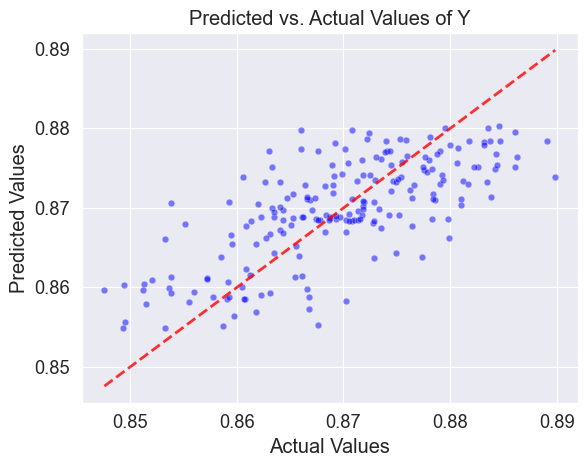

In [29]:
# Get predictions
predictions = best_model.predict(x_test)


## Compute the MSE
mse = mean_squared_error(y_true = y_test, y_pred = predictions)

# Compute the EVS
evs = explained_variance_score(y_true = y_test, y_pred = predictions)

# Print the MSE and EVS
print(f'Mean Square Error on the Test Set: {mse}')
print(f'Explained Variance Score on the Test Set: {evs}')

plt.figure()

sns.set_theme(context='paper', font_scale=1.5)
sns.scatterplot(x=y_test, y=predictions, color='blue', alpha=0.5)

## Adding the x=y line and the text
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, alpha = 0.8)

plt.title('Predicted vs. Actual Values of Y')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

#plt.savefig('Images/regression_toy_experiment.png', dpi=300, bbox_inches='tight',format="png")
plt.show()

Mean Square Error on the Test Set: 3.1914440438535835e-05
Explained Variance Score on the Test Set: 0.6230200162315849


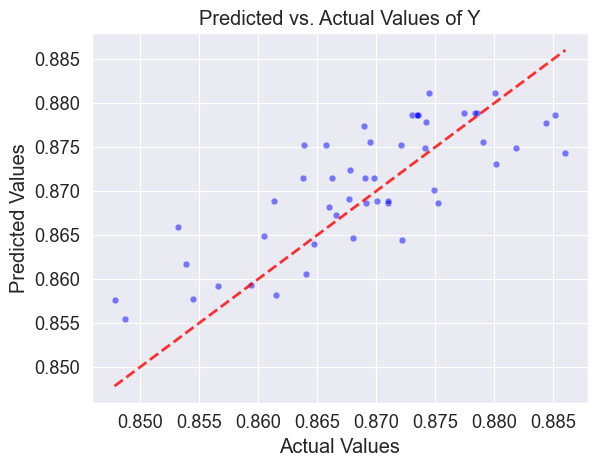

In [11]:
from catboost import CatBoostRegressor

# Initialize CatBoostRegressor
my_model = CatBoostRegressor(iterations = 10, 
                             learning_rate = 1,
                             depth = 2)
# Fit model
my_model.fit(x_train, y_train, verbose = False)
# Get predictions
predictions = my_model.predict(x_test)


## Compute the MSE
mse = mean_squared_error(y_true = y_test, y_pred = predictions)

# Compute the EVS
evs = explained_variance_score(y_true = y_test, y_pred = predictions)

# Print the MSE and EVS
print(f'Mean Square Error on the Test Set: {mse}')
print(f'Explained Variance Score on the Test Set: {evs}')

plt.figure()

sns.set_theme(context='paper', font_scale=1.5)
sns.scatterplot(x=y_test, y=predictions, color='blue', alpha=0.5)

## Adding the x=y line and the text
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, alpha = 0.8)

plt.title('Predicted vs. Actual Values of Y')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

#plt.savefig('Images/regression_toy_experiment.png', dpi=300, bbox_inches='tight',format="png")
plt.show()